# Setting

Mount your Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Set up mount symlink

In [2]:
DRIVE_PATH = '/content/gdrive/My\ Drive/ManipulationData'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/ManipulationData'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Import and others

In [3]:
%cd $SYM_PATH
%pwd

/content/gdrive/My Drive/ManipulationData


'/content/gdrive/My Drive/ManipulationData'

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [5]:
import pickle

## Loading Dataset

In [6]:
name_GIC = 'dataset_GIC_BC_CEV.pkl'
name_CIC = 'dataset_CIC_BC_GCEV.pkl'

saving_root = 'saved_model_CIC/BC_policy_CIC_GCEV_itr_'

file = open(name_CIC, 'rb')
dataset = pickle.load(file)

size = len(dataset['done'])

print(size)

1000000


In [7]:
dataset.keys()

dict_keys(['obs', 'done', 'actions'])

In [8]:
# eg_list = dataset['eg']
act_list = dataset['actions']
obs_list = dataset['obs']

obs = np.zeros((size, 6))
act = np.zeros((size, 6))

for i in range(size):
  # obs[i,:] = eg_list[i].reshape((-1,))
  obs[i,:] = obs_list[i]
  act[i,:] = act_list[i]

# obs = obs[:,:6]

In [20]:
obs_part = obs[:4000,:]

print(obs_part[1500,:])

[-5.69041466e-06 -2.45839149e-06 -2.63346354e-02  1.11978876e-04
 -2.28982634e-05  1.63141996e-06]


## dataset.py

In [21]:
import time

In [22]:
class BC_dataset(Dataset):
    def __init__(self, obs_arr, act_arr):
        self.obs_arr = torch.tensor(obs_arr, dtype = torch.float32)
        self.act_arr = torch.tensor(act_arr, dtype = torch.float32)

    def __len__(self):
        return self.obs_arr.shape[0]

    def __getitem__(self, idx):
        return (self.obs_arr[idx], self.act_arr[idx])

In [23]:
random_permute = np.random.permutation(size)

train_data = BC_dataset(obs[random_permute[:int(0.9*size)]], act[random_permute[:int(0.9*size)]])
valid_data = BC_dataset(obs[random_permute[int(0.9*size):]], act[random_permute[int(0.9*size):]])

train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=1024, shuffle=True)

# Model.py

In [24]:
class BCPolicy(nn.Module):
   def __init__(self, hidden_sizes, input_size=6, output_size=6, residual = False):
      super().__init__()

      self.hidden_activation = nn.ReLU()
      self.output_activation = nn.Tanh()

      self.fcs = []
      in_size = input_size
      for i, next_size in enumerate(hidden_sizes):
        fc = nn.Linear(in_size, next_size)
        in_size = next_size
        self.__setattr__("fc{}".format(i),fc)
        self.fcs.append(fc)

      self.last_fc = nn.Linear(in_size, output_size)

      self.residual = residual

   def forward(self, input):
      residual_ = False
      h = input
      for i,fc in enumerate(self.fcs):
        if self.residual:
          if i % 4 == 3:
            feedforward = h
            residual_ = True

        if residual_:
          h = fc(h)
          h += feedforward
          residual_ = False
        else:
          h = fc(h)
        h = self.hidden_activation(h)
      preactivation = self.last_fc(h)
      output = self.output_activation(preactivation)
      return output

# Training

In [25]:
def run_training_loop(model, train_loader, valid_loader, batch_size=1024, n_epochs=10, lr=1e-3, lr_decay = 0.99, device = None):

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

    # Use the cross entropy loss function
    # loss_fn = nn.L1Loss()
    loss_fn = nn.MSELoss()

    # store metrics
    train_loss_history = []
    valid_accuracy_history = []
    valid_loss_history = []
    model.to(device)

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (obs, act) in enumerate(train_loader):

            # Erase accumulated gradients
            optimizer.zero_grad()

            act = act.to(device)
            obs = obs.to(device)

            # Forward pass
            output = model(obs)


            # Calculate loss
            loss = loss_fn(output, act)
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Weight update
            optimizer.step()

        scheduler.step()

        train_loss_history.append(train_loss / len(train_loader.dataset))

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.7f' %
              (epoch + 1,  train_loss_history[-1]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for (obs, act) in valid_loader:
                act = act.to(device)
                obs = obs.to(device)
                output = model(obs)
                valid_loss += loss_fn(output, act).item()  # Sum up batch loss
                # pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                # correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history.append(valid_loss / len(valid_loader.dataset))
        valid_accuracy_history.append(correct / len(valid_loader.dataset))

        # print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
        #       (valid_loss_history[epoch], correct, len(valid_loader.dataset),
        #       100. * valid_accuracy_history[epoch]))
        print('Valid set: Average loss: %.7f \n' %
              (valid_loss_history[-1]))

        if epoch % 1 == 0:
          torch.save(model.state_dict(),saving_root+str(epoch)+'.pkl')

    return model, train_loss_history, valid_loss_history, valid_accuracy_history

In [26]:
sizes1 = [32] * 2
sizes2 = [32] * 4
sizes3 = [32] * 8
sizes4 = [32] * 16
sizes5 = [32] * 32

size_default = [128]*3

# hidden_sizes_list = [sizes1, sizes2, sizes3, sizes4, sizes5]
hidden_sizes_list = [size_default]

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses = []
valid_losses = []

for i in range(len(hidden_sizes_list)):
  model = BCPolicy(hidden_sizes_list[i], residual = False).float()
  model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model, train_loader, valid_loader, n_epochs = 40, lr=1e-3, device = device)
  train_losses.append(train_loss_history)
  valid_losses.append(valid_loss_history)

Train Epoch: 1  Average loss: 0.0000348
Valid set: Average loss: 0.0112564 

Train Epoch: 2  Average loss: 0.0000105
Valid set: Average loss: 0.0096510 

Train Epoch: 3  Average loss: 0.0000094
Valid set: Average loss: 0.0093513 

Train Epoch: 4  Average loss: 0.0000090
Valid set: Average loss: 0.0095440 

Train Epoch: 5  Average loss: 0.0000090
Valid set: Average loss: 0.0086455 

Train Epoch: 6  Average loss: 0.0000088
Valid set: Average loss: 0.0086005 

Train Epoch: 7  Average loss: 0.0000088
Valid set: Average loss: 0.0085629 

Train Epoch: 8  Average loss: 0.0000088
Valid set: Average loss: 0.0087297 

Train Epoch: 9  Average loss: 0.0000087
Valid set: Average loss: 0.0087262 

Train Epoch: 10  Average loss: 0.0000087
Valid set: Average loss: 0.0085052 

Train Epoch: 11  Average loss: 0.0000086
Valid set: Average loss: 0.0097670 

Train Epoch: 12  Average loss: 0.0000086
Valid set: Average loss: 0.0085466 

Train Epoch: 13  Average loss: 0.0000085
Valid set: Average loss: 0.00841

In [ ]:
# model = BCPolicy().float()

# device = "cuda:0"

# model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model, train_loader, valid_loader, n_epochs = 10, lr=1e-3, device = device)



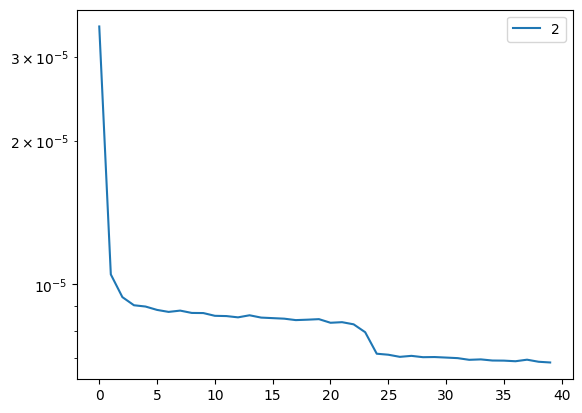

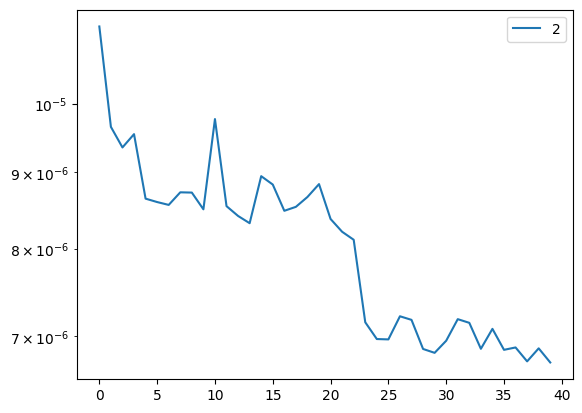

In [29]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(len(train_losses)):
  plt.plot(train_losses[i])
plt.yscale('log')

plt.legend(['2','4','8','16','32'])

plt.figure()
for i in range(len(valid_losses)):
  plt.plot(valid_losses[i])
plt.legend(['2','4','8','16','32'])
plt.yscale('log')


plt.show()